## Prepare input data

This notebook helps you load the experimental data from an excel file or a csv file, and plot it

Then you can use the next part to generate a config file for the bayesian inference 

In [1]:
# load the relevant modules for the analysis

from pathlib import Path
import os

import numpy as np
import pandas as pd
from scipy import interpolate

from pl_temp_fit import Exp_data_utils, config_utils

# access the right directory

os.chdir('/rds/general/user/hy2120/home/pl_temp_fit') 

In [2]:
exp_dataset_path =Path("/rds/general/user/hy2120/home/pl_temp_fit/60-300K/")


In [22]:
# Process the input data 
# if the data are in xlsx format convert them to csv
import pandas as pd
import glob
from scipy import interpolate
def from_xslx_to_csv(csv_name):
    try:
        #load excel file, but its called csv_name smh
        data = pd.read_excel(csv_name)
        #hw is in the first column
        hw_min = data.iloc[:, 0].min()
        hw_max = data.iloc[:, 0].max()
        hws = np.arange(hw_min,hw_max,0.01)

        y  = np.zeros((len(hws), len(data.columns)))
        y[:,0] = hws
        #store the interpolated stuff
        for i in range(1, len(data.columns)):
            f = interpolate.interp1d(data.iloc[:, 0], data.iloc[:, i], fill_value='extrapolate')
            y[:, i] = f(hws)

        data = pd.DataFrame(y, columns=data.columns)  
        data = data.transpose()
        data = data.rename(columns=data.iloc[0])[1:]
        # too many temps to process, specify every second one
        if data.shape[0]>10:
            data = data.iloc[range(0,data.shape[0],2),:]
        data.to_csv(f'{csv_name.replace(".xlsx",".csv")}')
        return f'{csv_name.replace(".xlsx",".csv")}'
    except Exception as e:
        print (f"Error processing {csv_name}: {e}")
        return None
xlsx_files = glob.glob('60-300K/*.xlsx')
for xlsx_file in glob.glob('60-300K/*.xlsx'):
    csv_name = from_xslx_to_csv(xlsx_file)
    print(csv_name)


60-300K/Y6-brilliantmat-sameday-fresh-300K_G0.csv
60-300K/Y6_1mat_300_G0_700.0nm_1500.0nm_20-06-2024-16h-21m_Exposure_3.0s.csv
60-300K/S3-Y6DIB-brilliantmat-sameday.csv
60-300K/Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024-17h-49m_Exposure_3.0s.csv
60-300K/Y6-brilliantmat-DIO-fresh-300K_G0.csv
60-300K/IT4F-soln.csv


In [3]:
# Read the experimental data available
csv_files = list(exp_dataset_path.glob("*.csv"))
string_to_find = "Y6"
for id, csv_file in enumerate(csv_files):
    if string_to_find in str(csv_file):  
        print(id, csv_file)

2 /rds/general/user/hy2120/home/pl_temp_fit/60-300K/Y6_1mat_300_G0_700.0nm_1500.0nm_20-06-2024-16h-21m_Exposure_3.0s.csv
4 /rds/general/user/hy2120/home/pl_temp_fit/60-300K/Y6-brilliantmat-sameday-fresh-300K_G0_mod_split0_split500.csv
6 /rds/general/user/hy2120/home/pl_temp_fit/60-300K/Y6-sameday-fresh-300K_G0.csv
10 /rds/general/user/hy2120/home/pl_temp_fit/60-300K/Y6-brilliantmat-sameday-fresh-300K_G0_mod_split60.0_split140.0.csv
11 /rds/general/user/hy2120/home/pl_temp_fit/60-300K/Y6DIO_1mat_sameday_300_G0_700.0nm_1500.0nm_20-06-2024-16h-15m_Exposure_3.0s.csv
12 /rds/general/user/hy2120/home/pl_temp_fit/60-300K/Y6-soln.csv
17 /rds/general/user/hy2120/home/pl_temp_fit/60-300K/S3-Y6DIB-brilliantmat-sameday_mod_split0_split500.csv
19 /rds/general/user/hy2120/home/pl_temp_fit/60-300K/Y6-brilliantmat-DIO-fresh-300K_G0_mod_split0_split500.csv
20 /rds/general/user/hy2120/home/pl_temp_fit/60-300K/Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024-17h-49m_Exposure_3.0s.csv


/rds/general/user/hy2120/home/pl_temp_fit/60-300K/Y6DIO_1mat_sameday_300_G0_700.0nm_1500.0nm_20-06-2024-16h-15m_Exposure_3.0s.csv


'/rds/general/user/hy2120/home/pl_temp_fit/60-300K/Y6DIO_1mat_sameday_300_G0_700.0nm_1500.0nm_20-06-2024-16h-15m_Exposure_3.0s.csv'

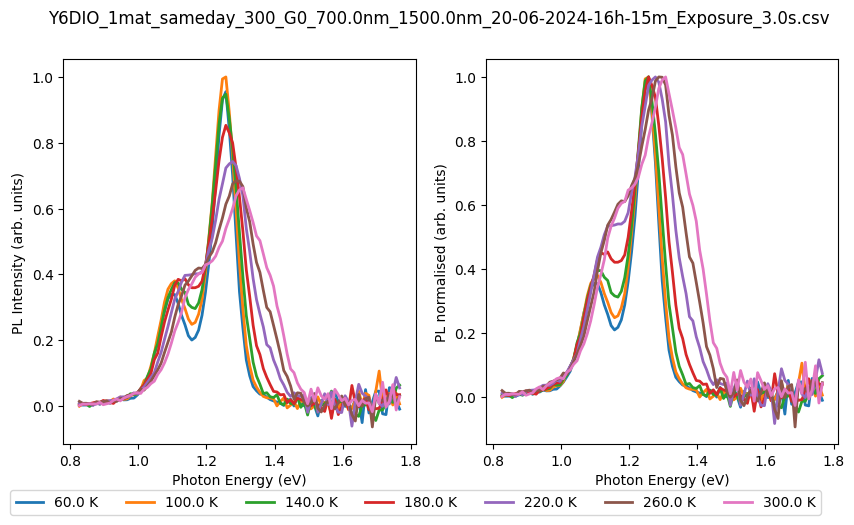

In [4]:
# choose the data to be analysed
# and plot them

csv_name = csv_files[11
                    ]
print(csv_name)
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
fig, ax = Exp_data_utils.plot_pl_data(
    
    Exp_data, temperature_list, hws, title=csv_name.name.split("/")[-1]
)
csv_name.absolute().as_posix()  

[ 60. 100. 140. 180. 220. 260. 300.]
/rds/general/user/hy2120/home/pl_temp_fit/60-300K/IEICO_cb-300K_G0_750.0nm_1600.0nm_16-07-2024-12h-41m_Exposure_5.0s_mod_split0_split500.csv
/rds/general/user/hy2120/home/pl_temp_fit/60-300K/IEICO_cb-300K_G0_750.0nm_1600.0nm_16-07-2024-12h-41m_Exposure_5.0s_mod_split0_split500.csv


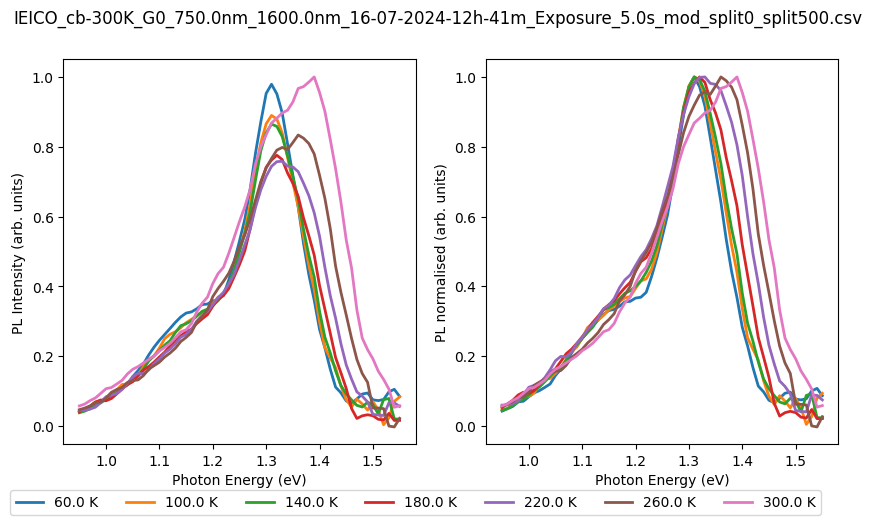

In [66]:
# modify the data if needed
def change_wavelength_range(
    csv_name, hws_limits=[0.95, 1.6], step=0.01, temperature_split=[]
):
    data, temperature_list_old, hws_old = Exp_data_utils.read_data(csv_name)
    print(temperature_list_old)
    temperature_split.append((0, 500))
    csv_names = []
    csv_name = csv_name.absolute().as_posix()
    for temp_split in temperature_split:
        temperature_list = temperature_list_old[
            temperature_list_old > temp_split[0]
        ]
        temperature_list = temperature_list[temperature_list < temp_split[1]]
        list_i = [
            i
            for i in range(len(temperature_list_old))
            if temperature_list_old[i] in temperature_list
        ]
        hws = np.arange(hws_limits[0], hws_limits[1], step)
        y = np.zeros((hws.size, 1 + len(temperature_list)))
        y[:, 0] = hws
        for _j, _i in enumerate(list_i):
            f = interpolate.interp1d(
                hws_old, data[:, _i], axis=0, fill_value="extrapolate"
            )
            y[:, _j + 1] = f(hws)
        data_new = np.zeros((len(temperature_list) + 1, len(hws) + 1))
        data_new[:, 1:] = y.transpose()
        data_new[1:, 0] = temperature_list
        data_new = pd.DataFrame(data_new, columns=["Temperature"] + list(hws))
        new_csv_name = f'{csv_name.replace(".csv",f"_mod_split{temp_split[0]}_split{temp_split[1]}.csv")}'
        data_new.to_csv(
            new_csv_name,
            index=None,
            header=None,
        )
        print(
            new_csv_name
        )
        csv_names.append(
            Path(new_csv_name)
        )
    temp_split = temperature_split[0]
    return csv_names


csv_names = change_wavelength_range(
    csv_name,
    hws_limits=[0.95, 1.55],
    step=0.01,
    temperature_split=[],
)
for xsc_name in csv_names:  
    Exp_data, temperature_list, hws = Exp_data_utils.read_data(xsc_name)
    fig, ax = Exp_data_utils.plot_pl_data(
        Exp_data, temperature_list, hws, title=xsc_name.name.split("/")[-1]
    )
    print(xsc_name) 


In [5]:
# initialise parameters for the model
import importlib

(
    number_free_parameters,
    Temp_std_err,
    hws_std_err,
    relative_intensity_std_error_pl,
    noise_sigma,
) = (5, 10, 0.005, 0.05, 0.01)
fixed_parameters_dict = {
    "EX": {"numbrstates": 20},
    "CT": {"off":1},
    "D": {},
}
params_to_fit_init = {
    "EX": {"E": 1.41, "sigma":0.1, "Li": 7.8e-2, "Lo": 0.11, "hO": 0.15},
#    "CT": {"E": 1.39, "sigma":1, "Li": 7.8e-2, "Lo": 0.11, "hO": 0.15, "log_fosc":-3},
    "CT": {},
#    "D": {"log_kEXCT":10},
    "D": {}
}
min_bounds = {
    "EX": {"E": 1.3, "sigma":0.01, "Li": 0.03, "Lo": 0.03, "hO": 0.14},
#    "CT": {"E": 1.2, "sigma":0.5, "Li": 0.03, "Lo": 0.03, "hO": 0.14, "log_fosc":-5},
    "CT": {},
#    "D": {"log_kEXCT":8},
    "D": {}
}
max_bounds = {
    "EX": {"E": 1.5, "sigma":0.2, "Li": 0.2, "Lo": 0.2, "hO": 0.16},
#    "CT": {"E": 1.45, "sigma":2, "Li": 0.2, "Lo": 0.2, "hO": 0.16, "log_fosc":-1},
    "CT": {},
#    "D": {"log_kEXCT":12},
    "D": {}
}
# save the model config
#for _csv_name in csv_names:
importlib.reload(config_utils)
model_config, test_id = config_utils.save_model_config(
        csv_name_pl=csv_name,
        Temp_std_err=Temp_std_err,
        hws_std_err=hws_std_err,
        relative_intensity_std_error_pl=relative_intensity_std_error_pl,
        temperature_list_pl=temperature_list,
        hws_pl=hws,
        noise_sigma=noise_sigma,
        fixed_parameters_dict=fixed_parameters_dict,
        params_to_fit_init=params_to_fit_init,
        min_bounds=min_bounds,
        max_bounds=max_bounds,
        num_iteration_max_likelihood=5,
        coeff_spread=0.5,
        nsteps=10000,
        num_coords=32,
        database_folder="fit_experimental_emcee_pl/fit_data_base/",
        data_folder="fit_experimental_emcee_pl/fit_data/",
    )
test_id

size of hw is (95,)
size of temperature_list is (7,)


'76f2e9d9-96c9-49ab-b4c7-1befff2161db'

## load model config and check 

In [9]:
# get test_ids in the database
import importlib
#model_config_files = glob.glob('fit_experimental_emcee_pl/fit_data_base/*.json')
model_config_files = Path("fit_experimental_emcee_pl/fit_data_base/").glob("*.json")
test_id_list = []
string_to_find = "Y6"
for id, model_config_file in enumerate(model_config_files):
    test_id = model_config_file.name.replace(".json", "")
    test_id_list.append(test_id)
    model_config, model_config_save = config_utils.load_model_config(
        test_id, database_folder="fit_experimental_emcee_pl/fit_data_base/"
    )
    if string_to_find in model_config_save["csv_name_pl"]:
        print(id, model_config_file)
        print(model_config_save["csv_name_pl"])
        print(model_config_save["fixed_parameters_dict"])


0 fit_experimental_emcee_pl/fit_data_base/677958b1-72d0-4144-99af-8e56157c1277.json
/rds/general/user/hy2120/home/pl_temp_fit/60-300K/Y6-brilliantmat-sameday-fresh-300K_G0.csv
{'EX': {'numbrstates': 20}, 'CT': {'off': 1}, 'D': {}}
1 fit_experimental_emcee_pl/fit_data_base/d04ac046-69e2-4a86-af35-208f8ec59890.json
/rds/general/user/hy2120/home/pl_temp_fit/60-300K/Y6-sameday-fresh-300K_G0.csv
{'EX': {'numbrstates': 20}, 'CT': {'off': 1}, 'D': {}}
2 fit_experimental_emcee_pl/fit_data_base/dc9d9a64-be51-44fb-9bfa-be3f7025287e.json
/rds/general/user/hy2120/home/pl_temp_fit/60-300K/Y6-brilliantmat-sameday-fresh-300K_G0.csv
{'EX': {'numbrstates': 20}, 'CT': {'off': 1}, 'D': {}}
3 fit_experimental_emcee_pl/fit_data_base/953ad0bd-446d-4c97-b73e-919e8da0a714.json
/rds/general/user/hy2120/home/pl_temp_fit/60-300K/Y6-brilliantmat-sameday-fresh-300K_G0.csv
{'EX': {'numbrstates': 20}, 'CT': {'off': 1}, 'D': {}}
4 fit_experimental_emcee_pl/fit_data_base/27c3ac85-2aa2-4561-bd90-371ca08ad1f6.json
/rds/

In [13]:
#importlib.reload(config_utils)
test_id = test_id_list[1]
model_config, model_config_save = config_utils.load_model_config(
    test_id, database_folder="fit_experimental_emcee_pl/fit_data_base/"
)
fixed_parameters_dict, params_to_fit, min_bound, max_bound = (
    config_utils.get_dict_params(model_config_save)
)
csv_name = Path(model_config_save["csv_name_pl"])
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
print(model_config_save["csv_name_pl"].split("/")[-1])
print(model_config_save["fixed_parameters_dict"])



Y6-brilliantmat-sameday-fresh-300K_G0.csv
{'EX': {'numbrstates': 20}, 'CT': {'off': 1}, 'D': {}}


shape of mean value plot is (109, 8)


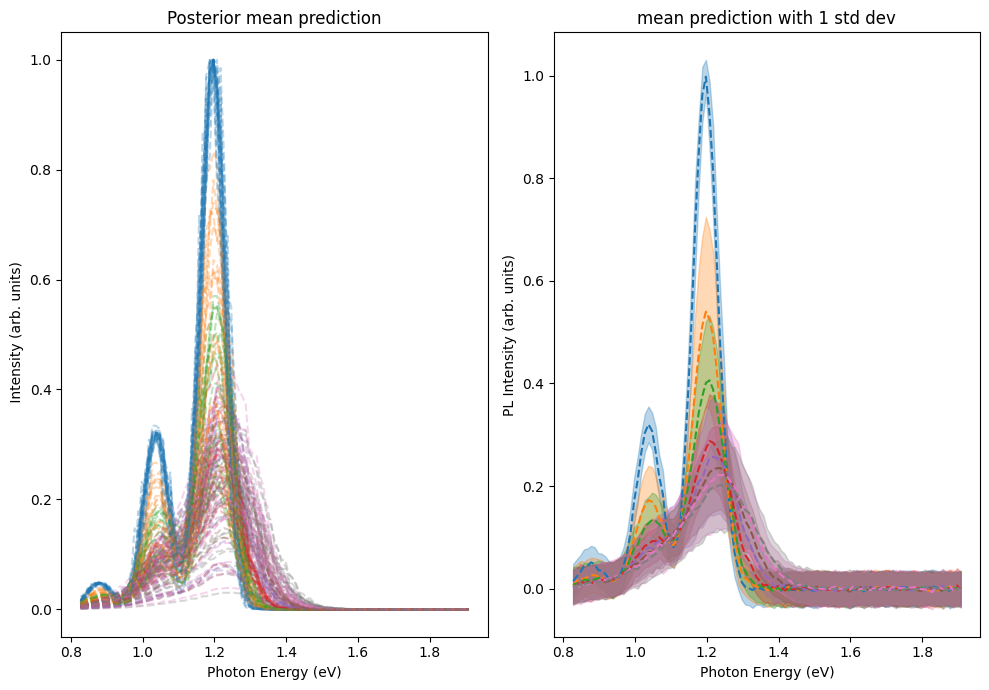

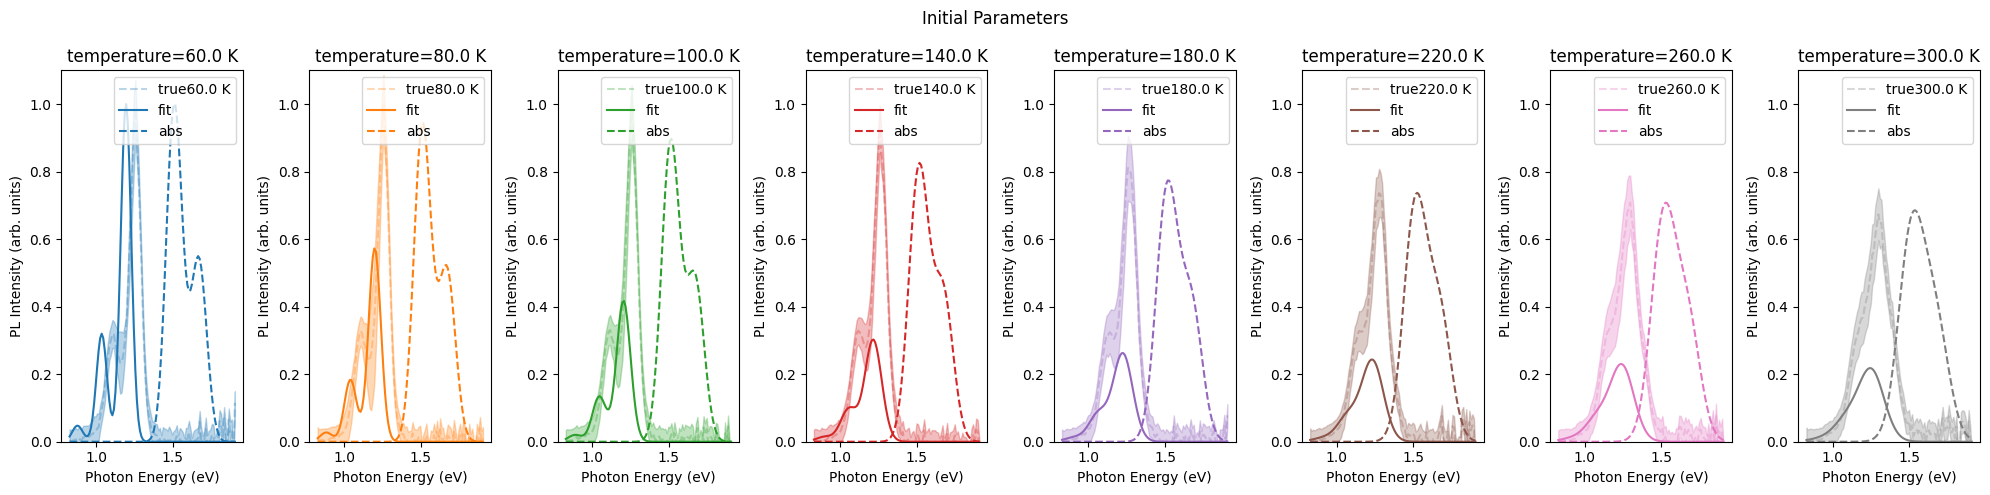

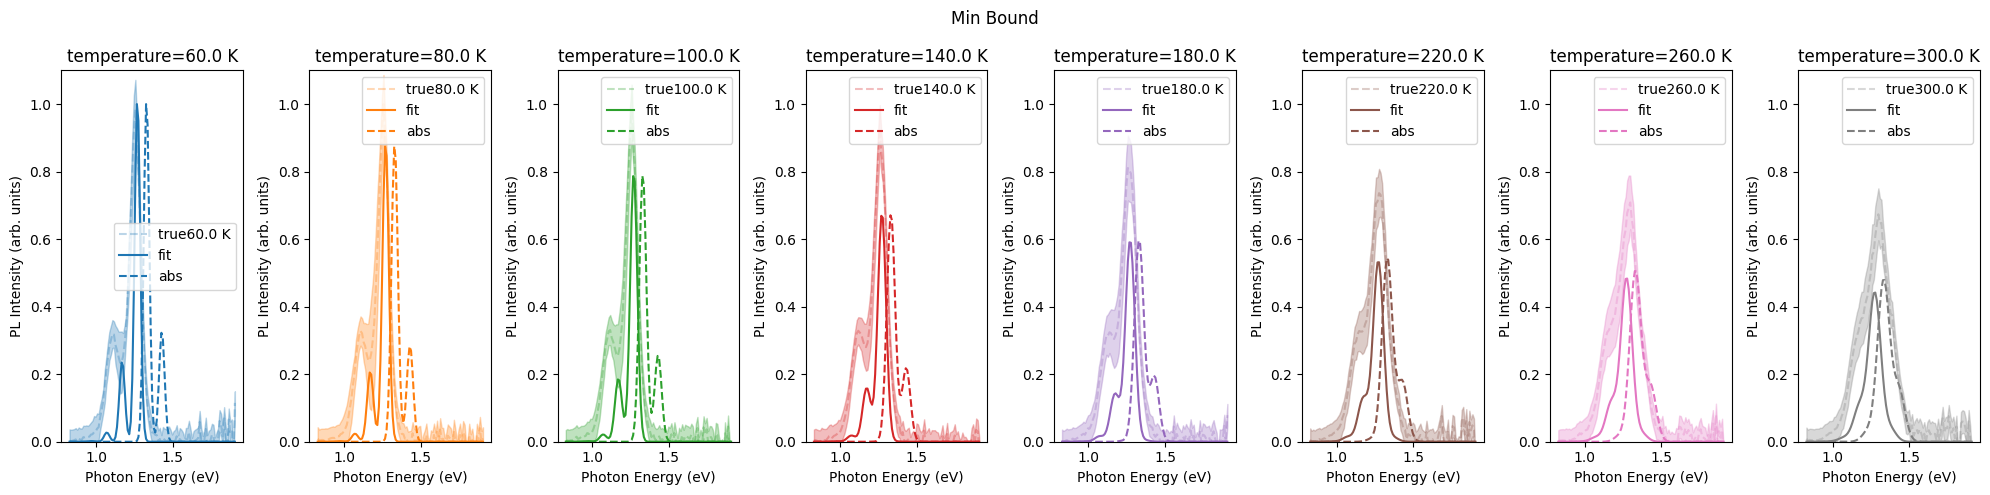

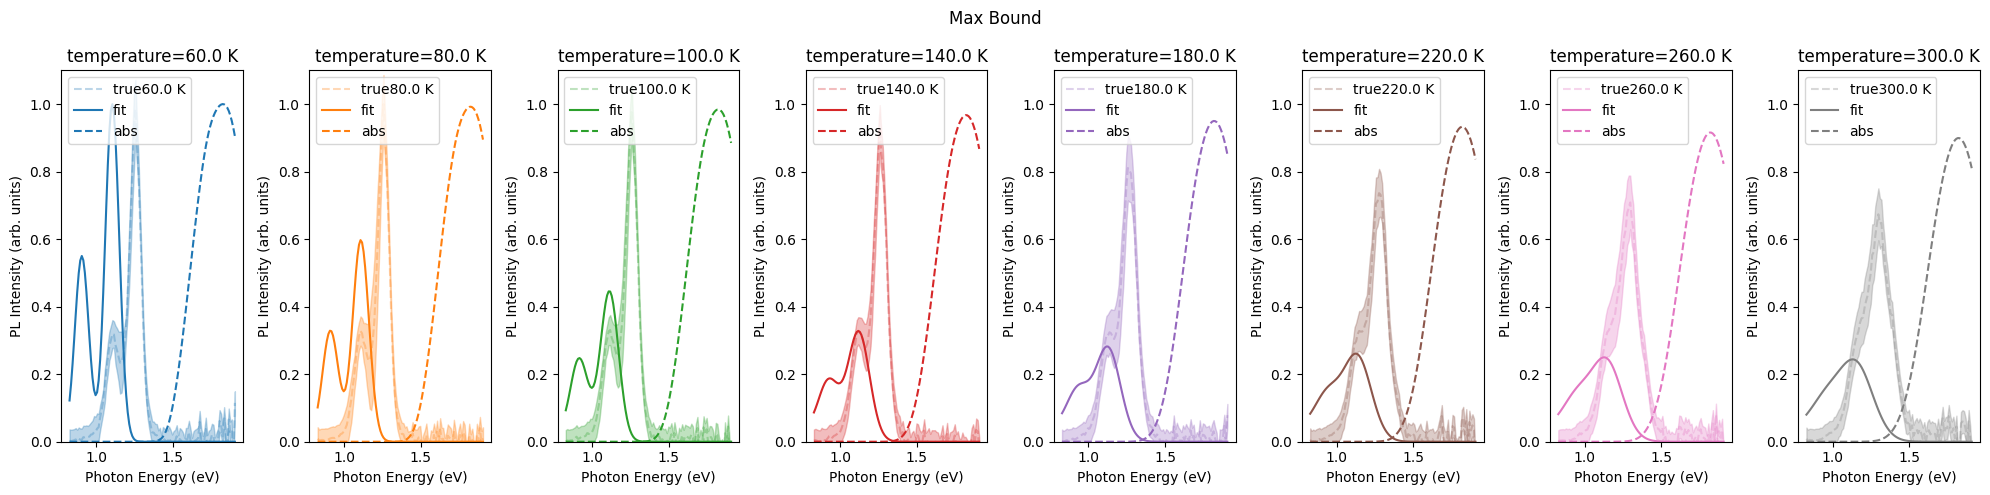

In [10]:
# plot the results with initial parameters
# and the maximum and minumum bounds
import importlib

from pl_temp_fit import fit_pl_utils

importlib.reload(fit_pl_utils)

fit_pl_utils.plot_fit_limits(model_config, model_config_save)

In [14]:
# modify the bounds
import importlib

importlib.reload(config_utils)

(
    number_free_parameters,
    Temp_std_err,
    hws_std_err,
    relative_intensity_std_error_pl,
    sigma,
) = (5, 10, 0.005, 0.05, 0.001)
params_to_fit_init = {
    "EX": {"E": 1.4, "sigma": 0.01, "Li": 7.8e-2, "Lo": 0.11, "hO": 0.159, "disorder_ext": 0.1},
    "CT": {},
    "D": {},
}
min_bounds = {
    "EX": {"E": 1.2, "sigma": 0.001, "Li": 0.03, "Lo": 0.03, "hO": 0.1, "disorder_ext": 0.1},
    "CT": {},
    "D": {},
}
max_bounds = {
    "EX": {"E": 1.6, "sigma": 0.1, "Li": 0.2, "Lo": 0.2, "hO": 0.2, "disorder_ext": 0.1},
    "CT": {},
    "D": {},
}
# save the model config
model_config, test_id = config_utils.save_model_config(
    csv_name_pl=csv_name,
    Temp_std_err=Temp_std_err,
    hws_std_err=hws_std_err,
    relative_intensity_std_error_pl=relative_intensity_std_error_pl,
    temperature_list_pl=temperature_list,
    hws_pl=hws,
    sigma=sigma,
    fixed_parameters_dict=fixed_parameters_dict,
    params_to_fit_init=params_to_fit_init,
    min_bounds=min_bounds,
    max_bounds=max_bounds,
    num_iteration_max_likelihood=5,
    coeff_spread=0.5,
    nsteps=10000,
    num_coords=32,
    database_folder="fit_experimental_emcee_pl/fit_data_base/",
    data_folder="fit_experimental_emcee_pl/fit_data/",
    test_id=test_id,
)
model_config_save["max_abs_pos_exp"] = 1.5
model_config_save["error_in_max_abs_pos"] = 0.01 # in eV
model_config_save["lifetime_exp_high_temp"] = 0.8e-9 # in seconds
model_config_save["error_in_lifetime_high_temp"]= 1e-10 # in seconds
config_utils.updata_model_config(test_id,path_database, model_config_save)

size of hw is (109,)
size of temperature_list is (8,)


NameError: name 'path_database' is not defined

In [27]:
csv_name

'/media/mohammed/Work/Work/pl_temp_fit/experiemental_data/2023-12-12-Lowtemp-PL/L8BO_mod_split200.0_split310.csv'